# El Kernel Zeta: Fundamento Matemático de Zeta Life

Este notebook explora el kernel fundamental que subyace a todo el proyecto Zeta Life:

$$K_\sigma(t) = 2 \sum_{n=1}^{M} e^{-\sigma |\gamma_n|} \cos(\gamma_n t)$$

Donde $\gamma_n$ son las partes imaginarias de los zeros no triviales de la función zeta de Riemann:
- $\gamma_1 = 14.134725...$
- $\gamma_2 = 21.022040...$
- $\gamma_3 = 25.010858...$
- ...

## Contenido
1. Los zeros de Riemann
2. Visualización del kernel
3. Efecto del parámetro σ
4. Comparación con kernel de Moore
5. Aplicación: Kernel 2D para autómatas celulares

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

# Configuración de visualización
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Colores del proyecto
COLORS = {
    'zeta': '#FFD700',      # Dorado
    'moore': '#888888',     # Gris
    'random': '#FF6B6B',    # Rojo
    'zeros': '#00CED1',     # Turquesa
}

## 1. Los Zeros No Triviales de Riemann

La función zeta de Riemann $\zeta(s)$ tiene zeros en $s = \frac{1}{2} + i\gamma_n$.

La **Hipótesis de Riemann** (no probada desde 1859) afirma que todos los zeros no triviales tienen parte real exactamente $\frac{1}{2}$.

Los primeros 30 zeros son:

In [2]:
# Primeros 30 zeros no triviales de la función zeta de Riemann
ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918720, 43.327073, 48.005151, 49.773832,
    52.970321, 56.446248, 59.347044, 60.831779, 65.112544,
    67.079811, 69.546402, 72.067158, 75.704691, 77.144840,
    79.337375, 82.910381, 84.735493, 87.425275, 88.809111,
    92.491899, 94.651344, 95.870634, 98.831194, 101.317851
])

print(f"Primeros 10 zeros γ_n:")
for i, gamma in enumerate(ZETA_ZEROS[:10], 1):
    print(f"  γ_{i:2d} = {gamma:.6f}")
print(f"  ...")
print(f"\nTotal de zeros disponibles: {len(ZETA_ZEROS)}")

Primeros 10 zeros γ_n:
  γ_ 1 = 14.134725
  γ_ 2 = 21.022040
  γ_ 3 = 25.010858
  γ_ 4 = 30.424876
  γ_ 5 = 32.935062
  γ_ 6 = 37.586178
  γ_ 7 = 40.918720
  γ_ 8 = 43.327073
  γ_ 9 = 48.005151
  γ_10 = 49.773832
  ...

Total de zeros disponibles: 30


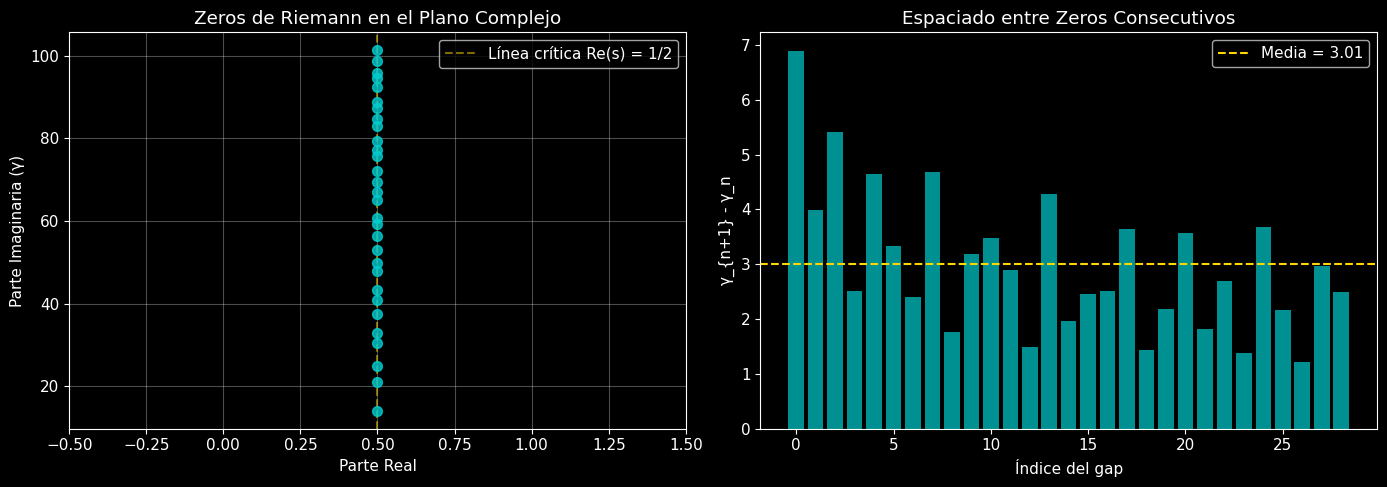


Estadísticas de espaciado:
  Mínimo: 1.219
  Máximo: 6.887
  Media:  3.006
  Std:    1.286


In [3]:
# Visualización de los zeros en el plano complejo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Panel izquierdo: Zeros en el plano complejo
ax1.scatter([0.5] * len(ZETA_ZEROS), ZETA_ZEROS, 
            c=COLORS['zeros'], s=50, alpha=0.8, zorder=5)
ax1.axvline(x=0.5, color=COLORS['zeta'], linestyle='--', alpha=0.5, 
            label='Línea crítica Re(s) = 1/2')
ax1.set_xlabel('Parte Real')
ax1.set_ylabel('Parte Imaginaria (γ)')
ax1.set_title('Zeros de Riemann en el Plano Complejo')
ax1.set_xlim(-0.5, 1.5)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel derecho: Distribución de gaps entre zeros consecutivos
gaps = np.diff(ZETA_ZEROS)
ax2.bar(range(len(gaps)), gaps, color=COLORS['zeros'], alpha=0.7)
ax2.axhline(y=np.mean(gaps), color=COLORS['zeta'], linestyle='--', 
            label=f'Media = {np.mean(gaps):.2f}')
ax2.set_xlabel('Índice del gap')
ax2.set_ylabel('γ_{n+1} - γ_n')
ax2.set_title('Espaciado entre Zeros Consecutivos')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nEstadísticas de espaciado:")
print(f"  Mínimo: {np.min(gaps):.3f}")
print(f"  Máximo: {np.max(gaps):.3f}")
print(f"  Media:  {np.mean(gaps):.3f}")
print(f"  Std:    {np.std(gaps):.3f}")

## 2. El Kernel Zeta $K_\sigma(t)$

El kernel es una superposición de oscilaciones con frecuencias dadas por los zeros:

$$K_\sigma(t) = 2 \sum_{n=1}^{M} e^{-\sigma |\gamma_n|} \cos(\gamma_n t)$$

- **$\sigma$**: Parámetro de regularización (decay). Controla cuánto contribuyen los zeros altos.
- **$M$**: Número de zeros a usar.

In [4]:
def zeta_kernel(t, sigma=0.1, M=15):
    """
    Calcula el kernel zeta K_σ(t).
    
    Args:
        t: Tiempo (escalar o array)
        sigma: Parámetro de regularización
        M: Número de zeros a usar
    
    Returns:
        Valor del kernel
    """
    t = np.atleast_1d(t)
    gammas = ZETA_ZEROS[:M]
    
    # Pesos exponenciales
    weights = np.exp(-sigma * np.abs(gammas))
    
    # Superposición de cosenos
    result = np.zeros_like(t, dtype=float)
    for gamma, w in zip(gammas, weights):
        result += 2 * w * np.cos(gamma * t)
    
    return result

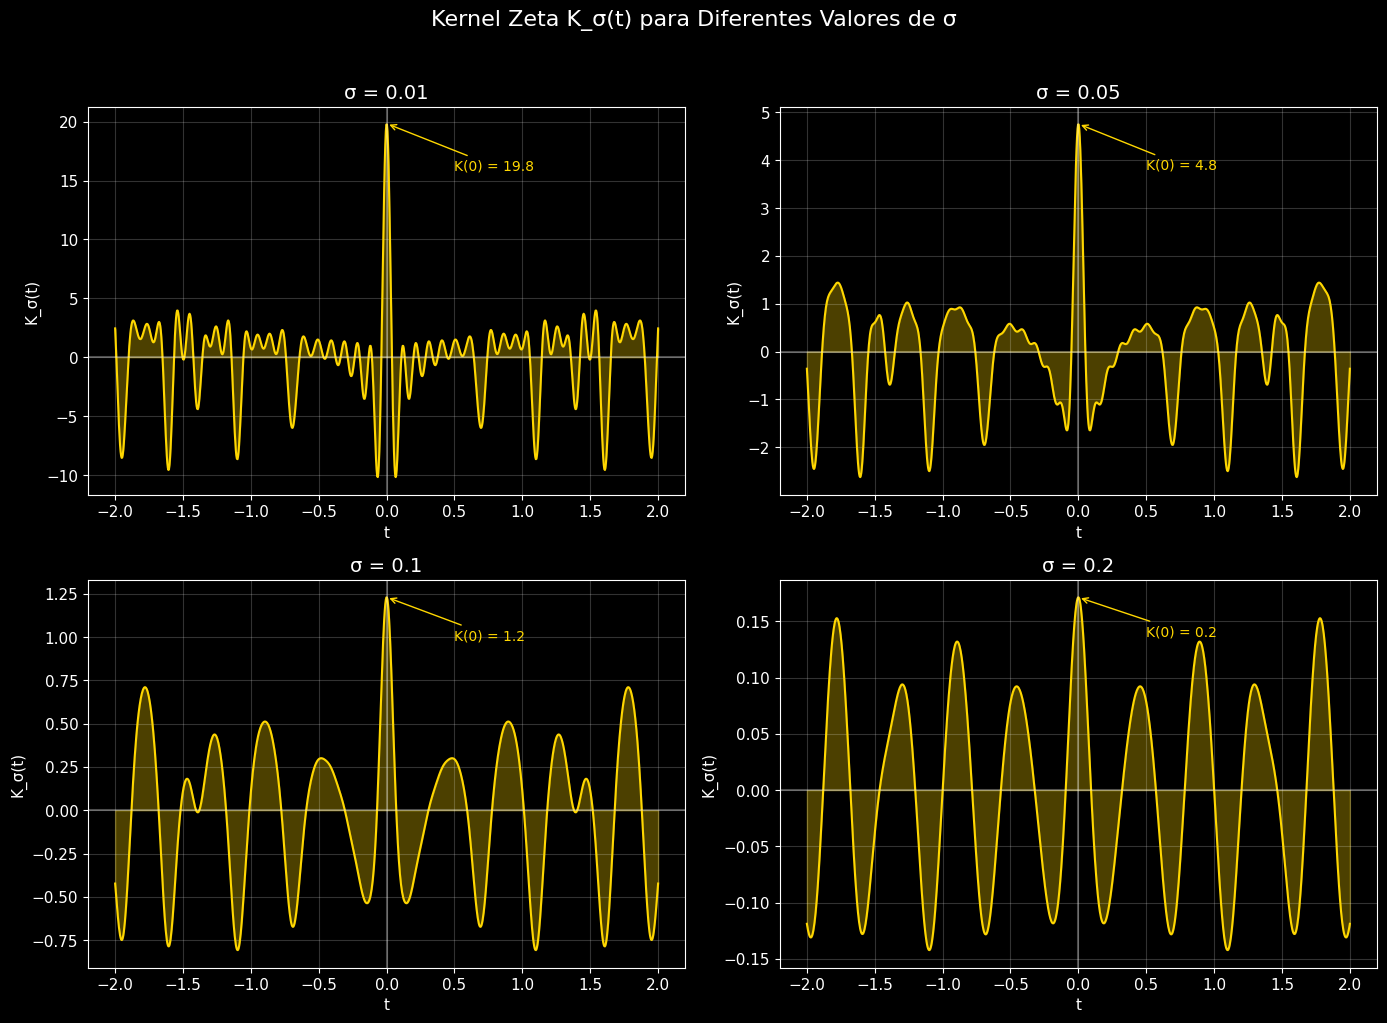

In [5]:
# Visualización del kernel para diferentes valores de σ
t = np.linspace(-2, 2, 1000)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sigmas = [0.01, 0.05, 0.1, 0.2]

for ax, sigma in zip(axes.flat, sigmas):
    K = zeta_kernel(t, sigma=sigma, M=15)
    
    ax.plot(t, K, color=COLORS['zeta'], linewidth=1.5)
    ax.fill_between(t, 0, K, alpha=0.3, color=COLORS['zeta'])
    ax.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='white', linestyle='-', alpha=0.3)
    
    ax.set_title(f'σ = {sigma}', fontsize=14)
    ax.set_xlabel('t')
    ax.set_ylabel('K_σ(t)')
    ax.grid(True, alpha=0.2)
    
    # Mostrar valor en t=0
    K0 = zeta_kernel(0, sigma=sigma, M=15)[0]
    ax.annotate(f'K(0) = {K0:.1f}', xy=(0, K0), xytext=(0.5, K0*0.8),
                fontsize=10, color=COLORS['zeta'],
                arrowprops=dict(arrowstyle='->', color=COLORS['zeta']))

plt.suptitle('Kernel Zeta K_σ(t) para Diferentes Valores de σ', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 3. Efecto del Parámetro σ (Regularización)

El parámetro $\sigma$ controla la **escala temporal** del kernel:
- **σ pequeño**: El kernel tiene oscilaciones rápidas (incluye zeros altos)
- **σ grande**: El kernel es más suave (domina el primer zero γ₁ ≈ 14.13)

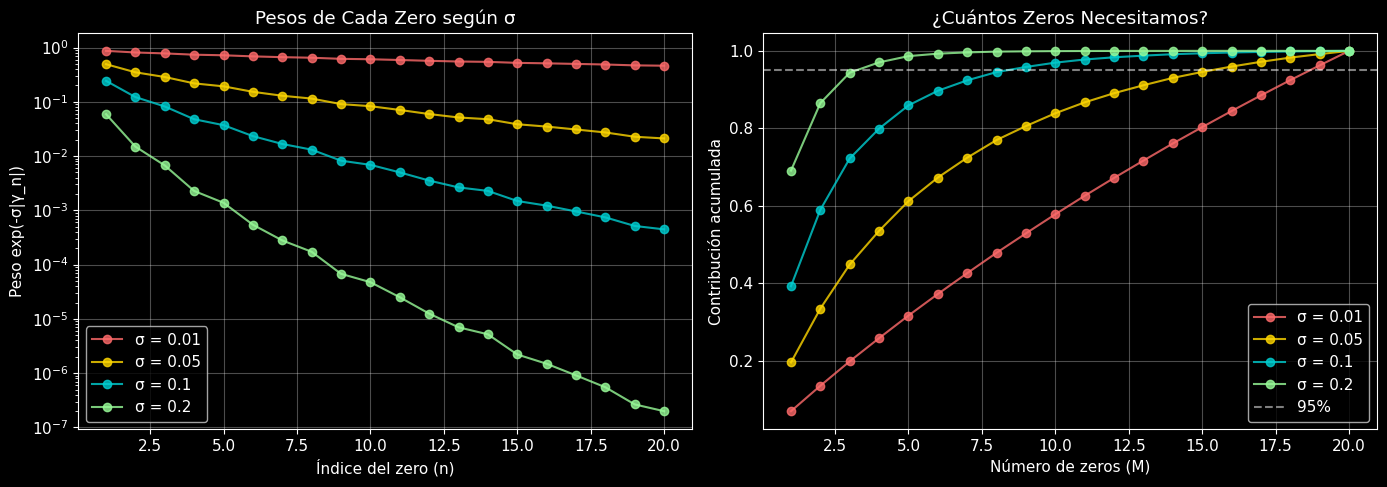


Zeros necesarios para 95% de contribución:
  σ = 0.01: M = 28
  σ = 0.05: M = 20
  σ = 0.1: M = 9
  σ = 0.2: M = 4


In [6]:
# Visualización de los pesos para diferentes σ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

M = 20
gammas = ZETA_ZEROS[:M]

# Panel izquierdo: Pesos para diferentes σ
for sigma, color in [(0.01, '#FF6B6B'), (0.05, '#FFD700'), (0.1, '#00CED1'), (0.2, '#98FB98')]:
    weights = np.exp(-sigma * gammas)
    ax1.plot(range(1, M+1), weights, 'o-', label=f'σ = {sigma}', 
             color=color, markersize=6, alpha=0.8)

ax1.set_xlabel('Índice del zero (n)')
ax1.set_ylabel('Peso exp(-σ|γ_n|)')
ax1.set_title('Pesos de Cada Zero según σ')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Panel derecho: Contribución acumulada
for sigma, color in [(0.01, '#FF6B6B'), (0.05, '#FFD700'), (0.1, '#00CED1'), (0.2, '#98FB98')]:
    weights = np.exp(-sigma * gammas)
    cumsum = np.cumsum(weights) / np.sum(weights)
    ax2.plot(range(1, M+1), cumsum, 'o-', label=f'σ = {sigma}',
             color=color, markersize=6, alpha=0.8)

ax2.axhline(y=0.95, color='white', linestyle='--', alpha=0.5, label='95%')
ax2.set_xlabel('Número de zeros (M)')
ax2.set_ylabel('Contribución acumulada')
ax2.set_title('¿Cuántos Zeros Necesitamos?')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular M efectivo para 95% de contribución
print("\nZeros necesarios para 95% de contribución:")
for sigma in [0.01, 0.05, 0.1, 0.2]:
    weights = np.exp(-sigma * ZETA_ZEROS)
    cumsum = np.cumsum(weights) / np.sum(weights)
    M_95 = np.searchsorted(cumsum, 0.95) + 1
    print(f"  σ = {sigma}: M = {M_95}")

## 4. Comparación: Kernel Zeta vs Moore vs Random

En autómatas celulares, tradicionalmente se usa el **kernel de Moore** (8 vecinos con peso uniforme).

Comparemos las propiedades espectrales:

In [7]:
def moore_kernel_1d(t, radius=1):
    """Kernel de Moore en 1D (vecindario uniforme)."""
    # Función rectangular centrada en 0
    return np.where(np.abs(t) <= radius, 1.0, 0.0)

def random_kernel(t, n_freqs=15, seed=42):
    """Kernel con frecuencias aleatorias (baseline)."""
    np.random.seed(seed)
    freqs = np.random.uniform(10, 100, n_freqs)
    weights = np.exp(-0.1 * freqs)
    
    result = np.zeros_like(t, dtype=float)
    for f, w in zip(freqs, weights):
        result += 2 * w * np.cos(f * t)
    return result

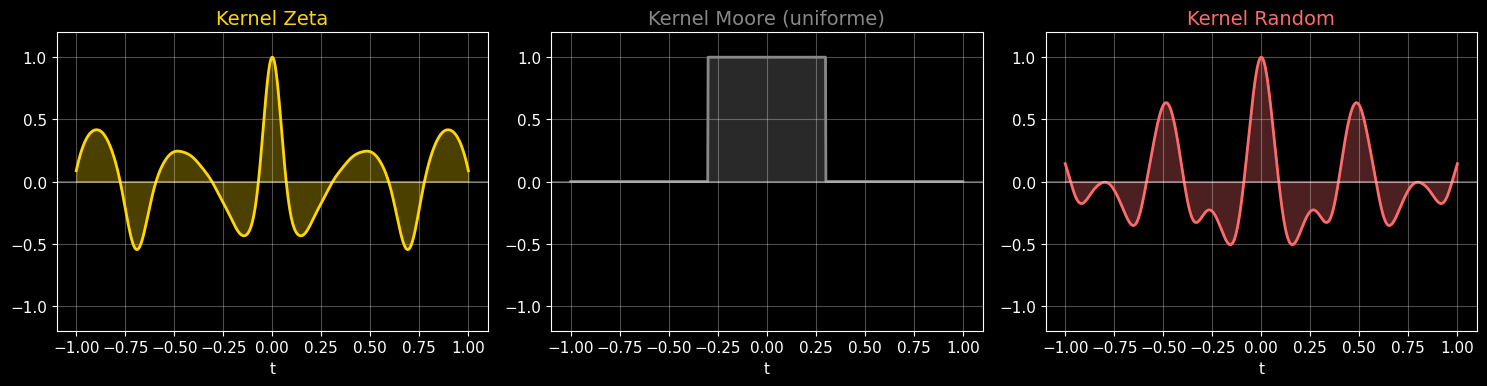

In [8]:
# Comparación visual de los tres kernels
t = np.linspace(-1, 1, 1000)

K_zeta = zeta_kernel(t, sigma=0.1, M=15)
K_moore = moore_kernel_1d(t, radius=0.3)
K_random = random_kernel(t)

# Normalizar para comparar
K_zeta_norm = K_zeta / np.max(np.abs(K_zeta))
K_moore_norm = K_moore / np.max(K_moore) if np.max(K_moore) > 0 else K_moore
K_random_norm = K_random / np.max(np.abs(K_random))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Kernel Zeta
axes[0].plot(t, K_zeta_norm, color=COLORS['zeta'], linewidth=2)
axes[0].fill_between(t, 0, K_zeta_norm, alpha=0.3, color=COLORS['zeta'])
axes[0].set_title('Kernel Zeta', fontsize=14, color=COLORS['zeta'])
axes[0].set_xlabel('t')
axes[0].grid(True, alpha=0.3)

# Kernel Moore
axes[1].plot(t, K_moore_norm, color=COLORS['moore'], linewidth=2)
axes[1].fill_between(t, 0, K_moore_norm, alpha=0.3, color=COLORS['moore'])
axes[1].set_title('Kernel Moore (uniforme)', fontsize=14, color=COLORS['moore'])
axes[1].set_xlabel('t')
axes[1].grid(True, alpha=0.3)

# Kernel Random
axes[2].plot(t, K_random_norm, color=COLORS['random'], linewidth=2)
axes[2].fill_between(t, 0, K_random_norm, alpha=0.3, color=COLORS['random'])
axes[2].set_title('Kernel Random', fontsize=14, color=COLORS['random'])
axes[2].set_xlabel('t')
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.set_ylim(-1.2, 1.2)
    ax.axhline(y=0, color='white', alpha=0.3)

plt.tight_layout()
plt.show()

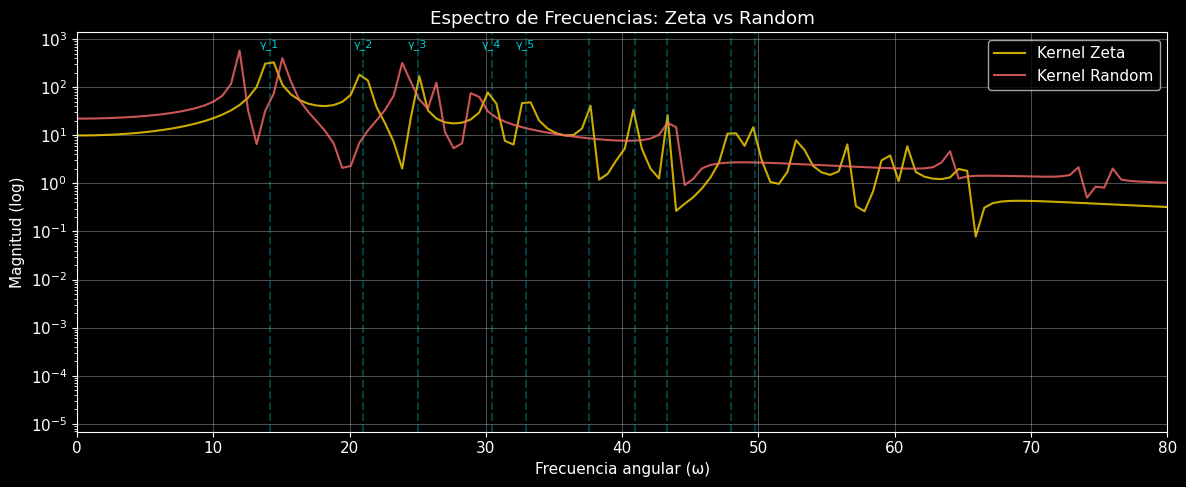


Observación: El kernel Zeta tiene picos exactamente en los zeros de Riemann.
Esto NO es coincidencia - es la estructura matemática fundamental.


In [9]:
# Análisis espectral (FFT)
from scipy.fft import fft, fftfreq

t_long = np.linspace(-5, 5, 2048)
dt = t_long[1] - t_long[0]

K_zeta_long = zeta_kernel(t_long, sigma=0.1, M=15)
K_random_long = random_kernel(t_long)

# FFT
fft_zeta = np.abs(fft(K_zeta_long))[:len(t_long)//2]
fft_random = np.abs(fft(K_random_long))[:len(t_long)//2]
freqs = fftfreq(len(t_long), dt)[:len(t_long)//2]

fig, ax = plt.subplots(figsize=(12, 5))

ax.semilogy(freqs * 2 * np.pi, fft_zeta, color=COLORS['zeta'], 
            label='Kernel Zeta', linewidth=1.5, alpha=0.8)
ax.semilogy(freqs * 2 * np.pi, fft_random, color=COLORS['random'], 
            label='Kernel Random', linewidth=1.5, alpha=0.8)

# Marcar los zeros de Riemann
for i, gamma in enumerate(ZETA_ZEROS[:10]):
    ax.axvline(x=gamma, color=COLORS['zeros'], alpha=0.3, linestyle='--')
    if i < 5:
        ax.text(gamma, ax.get_ylim()[1]*0.5, f'γ_{i+1}', 
                fontsize=8, color=COLORS['zeros'], ha='center')

ax.set_xlabel('Frecuencia angular (ω)')
ax.set_ylabel('Magnitud (log)')
ax.set_title('Espectro de Frecuencias: Zeta vs Random')
ax.set_xlim(0, 80)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservación: El kernel Zeta tiene picos exactamente en los zeros de Riemann.")
print("Esto NO es coincidencia - es la estructura matemática fundamental.")

## 5. Kernel 2D para Autómatas Celulares

Para usar el kernel en un autómata celular 2D, lo extendemos radialmente:

$$K_{2D}(x, y) = K_\sigma(\sqrt{x^2 + y^2})$$

In [10]:
def zeta_kernel_2d(size=11, sigma=0.1, M=15):
    """
    Genera un kernel 2D basado en el kernel zeta.
    
    Args:
        size: Tamaño del kernel (debe ser impar)
        sigma: Parámetro de regularización
        M: Número de zeros
    
    Returns:
        Kernel 2D normalizado
    """
    center = size // 2
    y, x = np.ogrid[-center:center+1, -center:center+1]
    
    # Distancia radial normalizada
    r = np.sqrt(x**2 + y**2) / center
    
    # Aplicar kernel zeta
    kernel = zeta_kernel(r.flatten(), sigma=sigma, M=M).reshape(size, size)
    
    # Normalizar
    kernel = kernel / np.sum(np.abs(kernel))
    
    return kernel

def moore_kernel_2d(size=3):
    """Kernel de Moore clásico (todos los vecinos con peso 1)."""
    kernel = np.ones((size, size))
    kernel[size//2, size//2] = 0  # Centro = 0
    return kernel / np.sum(kernel)

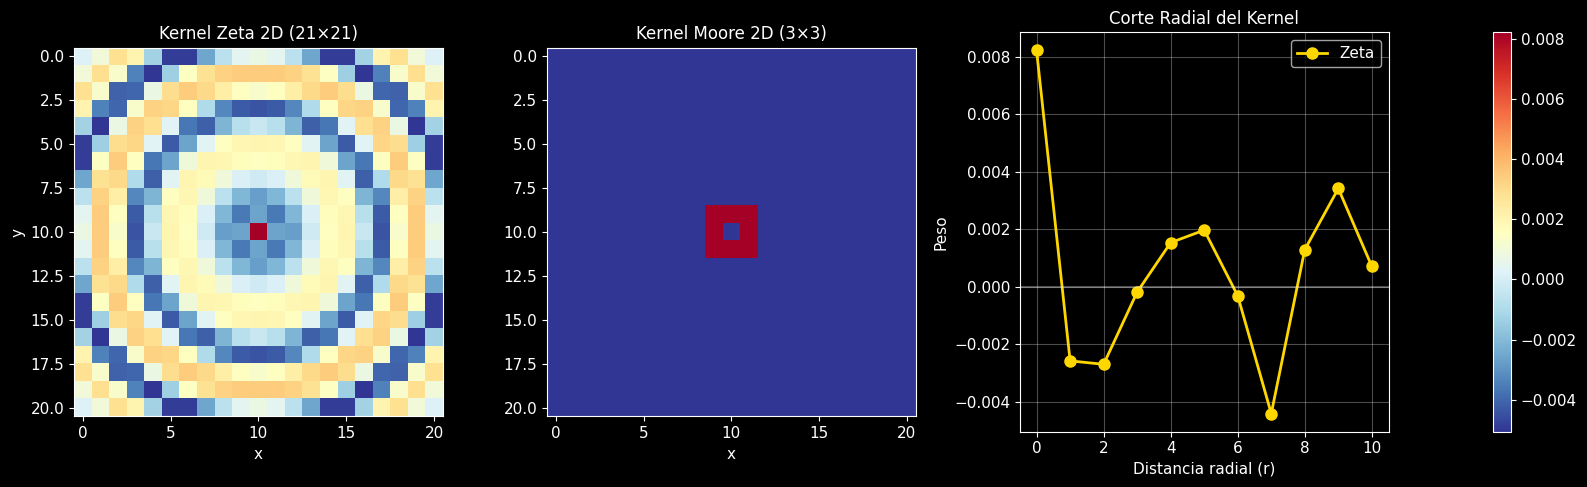


Kernel Zeta 2D:
  Tamaño: (21, 21)
  Suma: -0.0095
  Min/Max: -0.0051 / 0.0082
  Valores negativos: 180 celdas


In [11]:
# Visualización de kernels 2D
fig = plt.figure(figsize=(16, 5))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])

# Kernel Zeta 2D
ax1 = fig.add_subplot(gs[0])
K_zeta_2d = zeta_kernel_2d(size=21, sigma=0.1, M=15)
im1 = ax1.imshow(K_zeta_2d, cmap='RdYlBu_r', aspect='equal')
ax1.set_title('Kernel Zeta 2D (21×21)', fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Kernel Moore 2D
ax2 = fig.add_subplot(gs[1])
K_moore_2d = moore_kernel_2d(size=3)
# Pad para visualizar mejor
K_moore_padded = np.zeros((21, 21))
K_moore_padded[9:12, 9:12] = K_moore_2d * 10  # Escalar para visualizar
im2 = ax2.imshow(K_moore_padded, cmap='RdYlBu_r', aspect='equal')
ax2.set_title('Kernel Moore 2D (3×3)', fontsize=12)
ax2.set_xlabel('x')

# Corte radial de ambos kernels
ax3 = fig.add_subplot(gs[2])
center = 10
r_values = np.arange(0, 11)
zeta_radial = [K_zeta_2d[center, center + r] for r in r_values]

ax3.plot(r_values, zeta_radial, 'o-', color=COLORS['zeta'], 
         label='Zeta', linewidth=2, markersize=8)
ax3.axhline(y=0, color='white', alpha=0.3)
ax3.set_xlabel('Distancia radial (r)')
ax3.set_ylabel('Peso')
ax3.set_title('Corte Radial del Kernel', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Colorbar
cax = fig.add_subplot(gs[3])
plt.colorbar(im1, cax=cax)

plt.tight_layout()
plt.show()

print(f"\nKernel Zeta 2D:")
print(f"  Tamaño: {K_zeta_2d.shape}")
print(f"  Suma: {np.sum(K_zeta_2d):.4f}")
print(f"  Min/Max: {K_zeta_2d.min():.4f} / {K_zeta_2d.max():.4f}")
print(f"  Valores negativos: {np.sum(K_zeta_2d < 0)} celdas")

## 6. Visualización 3D del Kernel

Una vista tridimensional ayuda a entender la estructura del kernel:

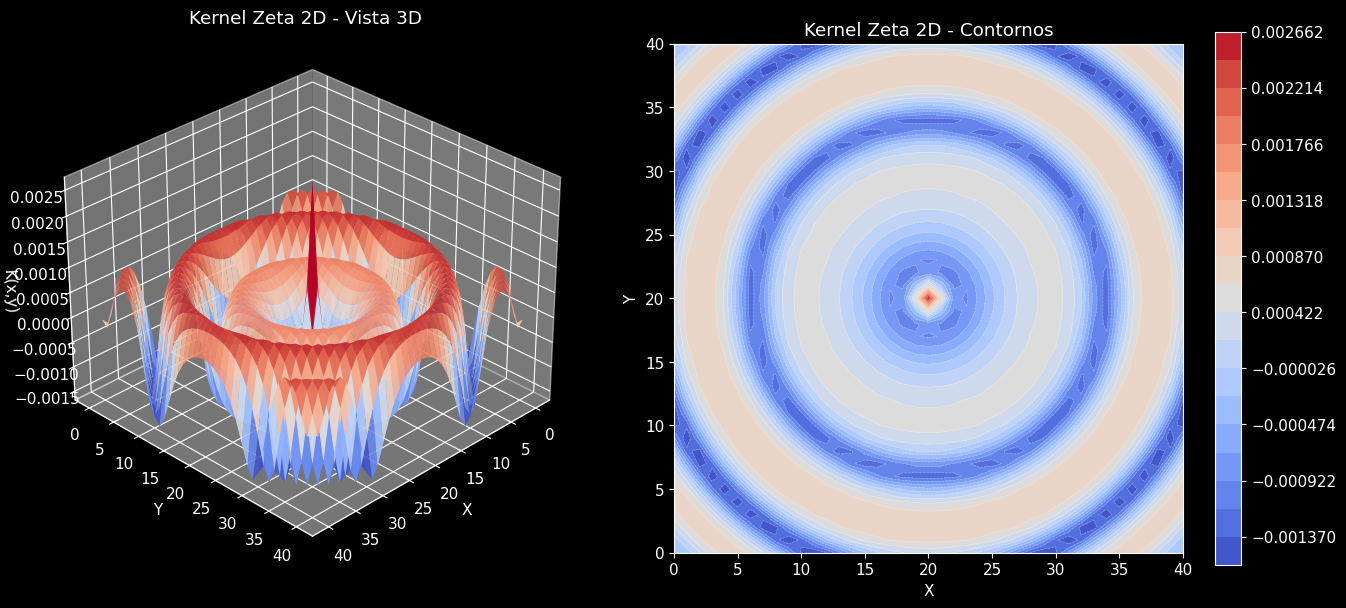

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Crear kernel de mayor resolución para visualización 3D
K_3d = zeta_kernel_2d(size=41, sigma=0.08, M=20)

# Coordenadas
x = np.arange(K_3d.shape[0])
y = np.arange(K_3d.shape[1])
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(14, 6))

# Vista 3D superficie
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, K_3d, cmap='coolwarm', 
                        linewidth=0, antialiased=True, alpha=0.9)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('K(x,y)')
ax1.set_title('Kernel Zeta 2D - Vista 3D')
ax1.view_init(elev=30, azim=45)

# Contornos
ax2 = fig.add_subplot(122)
levels = np.linspace(K_3d.min(), K_3d.max(), 20)
contour = ax2.contourf(X, Y, K_3d, levels=levels, cmap='coolwarm')
ax2.contour(X, Y, K_3d, levels=levels, colors='white', alpha=0.3, linewidths=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Kernel Zeta 2D - Contornos')
ax2.set_aspect('equal')
plt.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()

## 7. Propiedades Matemáticas

El kernel zeta tiene propiedades únicas derivadas de la función zeta de Riemann:

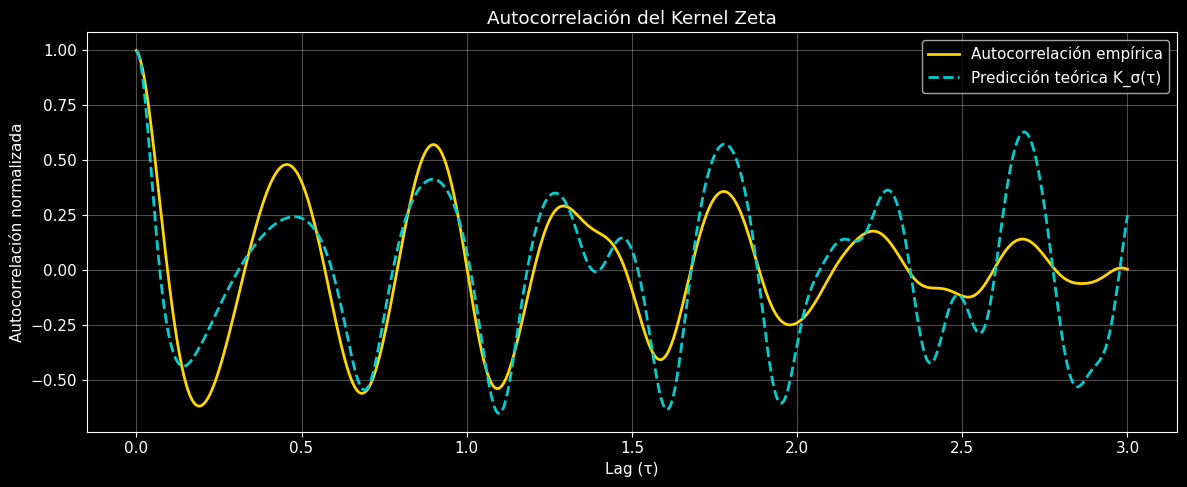


Propiedad clave: La autocorrelación del kernel zeta
sigue la misma forma funcional K_σ(τ).

Esto implica invariancia bajo auto-convolución,
una propiedad única derivada de los zeros de Riemann.


In [13]:
# Autocorrelación del kernel
t = np.linspace(0, 3, 500)
K = zeta_kernel(t, sigma=0.1, M=20)

# Autocorrelación teórica: también sigue el kernel zeta
autocorr_empirica = np.correlate(K, K, mode='full')
autocorr_empirica = autocorr_empirica[len(autocorr_empirica)//2:]
autocorr_empirica = autocorr_empirica / autocorr_empirica[0]

# Kernel normalizado como predicción teórica
K_teorico = zeta_kernel(t, sigma=0.1, M=20)
K_teorico = K_teorico / K_teorico[0]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(t, autocorr_empirica[:len(t)], color=COLORS['zeta'], 
        linewidth=2, label='Autocorrelación empírica')
ax.plot(t, K_teorico, '--', color=COLORS['zeros'], 
        linewidth=2, label='Predicción teórica K_σ(τ)')

ax.set_xlabel('Lag (τ)')
ax.set_ylabel('Autocorrelación normalizada')
ax.set_title('Autocorrelación del Kernel Zeta')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPropiedad clave: La autocorrelación del kernel zeta")
print("sigue la misma forma funcional K_σ(τ).")
print("\nEsto implica invariancia bajo auto-convolución,")
print("una propiedad única derivada de los zeros de Riemann.")

## Resumen

El **Kernel Zeta** $K_\sigma(t)$ es el fundamento matemático de Zeta Life:

| Propiedad | Descripción |
|-----------|-------------|
| **Basado en zeros de Riemann** | Frecuencias γ_n determinadas por la matemática más profunda |
| **Regularización σ** | Controla el rango temporal/espacial de influencia |
| **Estructura multi-escala** | Diferentes zeros capturan diferentes escalas |
| **Auto-similaridad** | Autocorrelación sigue la misma forma funcional |
| **Extensible a 2D** | Kernel radial para autómatas celulares y campos de fuerza |

### Aplicaciones en el Proyecto

1. **Zeta Game of Life**: Kernel 2D reemplaza vecindario de Moore
2. **ZetaOrganism**: Campo de fuerza con decaimiento zeta
3. **ZetaLSTM**: Memoria temporal con correlaciones zeta
4. **ZetaPsyche**: Modulación de arquetipos con frecuencias zeta

---

*"Los zeros de Riemann no son números arbitrarios - codifican la estructura más profunda de los números primos, y por extensión, de la realidad matemática."*